# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 3, #number of variables
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_56_drop0.25e500b512_custom/lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_5_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_5_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 216
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '015', '020', '021', '022', '023', '024', '025', '030', '031', '032', '033', '034', '035', '040', '041', '042', '043', '044', '045', '050', '051', '052', '053', '054', '055', '100', '101', '102', '103', '104', '105', '110', '111', '112', '113', '114', '115', '120', '121', '122', '123', '124', '125', '130', '131', '132', '133', '134', '135', '140', '141', '142', '143', '144', '145', '150', '151', '152', '153', '154', '155', '200', '201', '202', '203', '204', '205', '210', '211', '212', '213', '214', '215', '220', '221', '222', '223', '224', '225', '230', '231', '232', '233', '234', '235', '240', '241', '242', '243', '244', '245', '250', '251', '252', '253', '254', '255', '300', '301', '302', '303', '304', '305', '310', '311', '312', '313', '314', '315', '320', '321', '322', '323', '324', '325', '330', '331', '33

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 56
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '020', '021', '022', '023', '030', '031', '032', '040', '041', '050', '100', '101', '102', '103', '104', '110', '111', '112', '113', '120', '121', '122', '130', '131', '140', '200', '201', '202', '203', '210', '211', '212', '220', '221', '230', '300', '301', '302', '310', '311', '320', '400', '401', '410', '500']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.3min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 1570)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 1570)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 1570)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Interpretation Network Training

In [ ]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 40 Complete [00h 22m 36s]
val_loss: 0.027103209868073463

Best val_loss So Far: 0.027103209868073463
Total elapsed time: 04h 42m 07s

Search: Running Trial #41

Hyperparameter    |Value             |Best Value So Far 
dense_block_1/u...|False             |False             
dense_block_1/n...|1                 |1                 
dense_block_1/u...|512               |512               
dense_block_1/d...|0.25              |0.25              
dense_block_1/u...|512               |512               
regression_head...|0.5               |0                 
optimizer         |adam_weight_decay |adam_weight_decay 
learning_rate     |0.0001            |0.0001            
dense_block_1/u...|128               |128               

Epoch 1/500
254/254 [==============================] - 12s 48ms/step - loss: 0.2990 - val_loss: 0.2297
Epoch 2/500
254/254 [==============================] - 11s 44ms/step - loss: 0.2642 - val_loss: 0.2000
Epoch 3/500
254/254 [==============================] - 1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 11s 44ms/step - loss: 0.0693 - val_loss: 0.0446
Epoch 37/500
254/254 [==============================] - 11s 45ms/step - loss: 0.0691 - val_loss: 0.0433
Epoch 38/500
254/254 [==============================] - 11s 44ms/step - loss: 0.0687 - val_loss: 0.0484
Epoch 39/500
254/254 [==============================] - 12s 45ms/step - loss: 0.0682 - val_loss: 0.0457
Epoch 40/500
254/254 [==============================] - 11s 44ms/step - loss: 0.0679 - val_loss: 0.0415
Epoch 41/500
254/254 [==============================] - 11s 44ms/step - loss: 0.0673 - val_loss: 0.0423
Epoch 42/500
254/254 [==============================] - 11s 44ms/step - loss: 0.0675 - val_loss: 0.0419
Epoch 43/500
254/254 [==============================] - 11s 43ms/step - loss: 0.0668 - val_loss: 0.0421
Epoch 44/500
254/254 [==============================] - 11s 43ms/step - loss: 0.0670 - val_loss: 0.0428
Epoch 45/500
254/254 [==============================] - 11s 44ms/step - loss:

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 38ms/step - loss: 0.2710 - val_loss: 0.2570
Epoch 2/500
254/254 [==============================] - 9s 35ms/step - loss: 0.2686 - val_loss: 0.2541
Epoch 3/500
176/254 [===================>..........] - ETA: 2s - loss: 0.2665

## Evaluate Interpretation Net

In [59]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 512
dense_block_1/dropout: 0.25
dense_block_1/units_1: 512
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 128
Score: 0.027103209868073463
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 512
dense_block_1/dropout: 0.25
dense_block_1/units_1: 512
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 1024
Score: 0.02806742861866951
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 512
dense_block_1/dropout: 0.25
dense_block_1/units_1: 512
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 32
Score: 0.029125940054655075
None
Trial summary
Hyperparameters:
dense_block_1/us

In [60]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1401)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 1401)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               717824    
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1457)              747441    
Total params: 1,465,265
Trainable params: 1,465,265
Non-trainable params: 0
____________________________________________

In [61]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.088,0.159,4.230,0.518,0.000,0.025,0.034,1.333,0.961,0.126,0.565,0.030,0.014,0.014,0.382,0.393
inetPoly_VS_targetPoly_test,0.089,0.160,3.373,0.513,0.000,0.025,0.034,0.950,0.962,0.124,0.546,0.031,0.009,0.009,0.403,0.413
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.024,0.031,1.217,0.968,0.120,0.420,0.027,0.014,0.014,0.382,0.389
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.024,0.031,0.932,0.970,0.118,0.417,0.028,0.009,0.009,0.403,0.410
inetPoly_VS_lstsqTarget_valid,1.074,1.715,140.173,0.065,0.000,0.024,0.031,1.428,0.969,0.119,0.416,0.026,0.014,0.014,0.382,0.389
inetPoly_VS_lstsqTarget_test,1.115,1.791,107.894,0.062,0.000,0.024,0.031,0.948,0.970,0.118,0.416,0.027,0.009,0.009,0.403,0.410
inetPoly_VS_lstsqLambda_valid,1.074,1.715,140.173,0.065,0.000,0.024,0.031,1.428,0.969,0.119,0.416,0.026,0.014,0.014,0.382,0.389
inetPoly_VS_lstsqLambda_test,1.115,1.791,107.894,0.062,0.000,0.024,0.031,0.948,0.970,0.118,0.416,0.027,0.009,0.009,0.403,0.410
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.241,0.999,0.018,0.093,0.005,0.014,0.014,0.389,0.389
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.227,0.999,0.018,0.093,0.005,0.009,0.009,0.410,0.410


In [62]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.025,0.019,0.032,0.027,0.031,0.019,0.018,0.023,0.018,0.021,0.042,0.021,0.022,0.021,0.046,0.030,0.019,0.025,0.016,0.018,0.017,0.015,0.030,0.031,0.045,0.019,0.013,0.106,0.013,0.016,0.015,0.014,0.023,0.035,0.035,0.027,0.013,0.022,0.016,0.124,0.024,0.014,0.021,0.017,0.028,0.021,0.020,0.037,0.036,0.020,0.032,0.016,0.019,0.015,0.026,0.023,0.011,0.020,0.015,0.034,0.018,0.021,0.038,0.031,0.025,0.027,0.042,0.009,0.021,0.016,0.033,0.020,0.040,0.021,0.066,0.035,0.051,0.022,0.017,0.016,0.016,0.036,0.017,0.039,0.020,0.032,0.026,0.025,0.020,0.014,0.020,0.016,0.026,0.016,0.023,0.027,0.033,0.048,0.021,0.038,0.028,0.014,0.037,0.025,0.036,0.028,0.019,0.031,0.037,0.016,0.015,0.019,0.038,0.016,0.025,0.031,0.014,0.036,0.011,0.025,0.014,0.037,0.015,0.037,0.024,0.016,0.030,0.019,0.016,0.019,0.026,0.021,0.021,0.024,0.038,0.016,0.036,0.018,0.030,0.042,0.023,0.021,0.020,0.024,0.014,0.049,0.027,0.065,0.026,0.012,0.011,0.020,0.028,0.019,0.028,0.027,0.012,0.017,0.021,0.012,0.020,0.018,0.014,0.015,0.045,0.020,0.034,0.017,0.015,0.019,0.042,0.035,0.018,0.044,0.021,0.021,0.010,0.039,0.038,0.

In [63]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.964,0.990,0.988,0.908,0.975,0.984,0.975,0.938,0.991,0.982,0.989,0.979,0.985,0.945,0.988,0.981,0.985,0.981,0.989,0.975,0.947,0.980,0.971,0.982,0.979,0.798,0.961,0.701,0.975,0.987,0.988,0.996,0.985,0.901,0.964,0.898,0.972,0.988,0.986,0.754,0.984,0.986,0.988,0.971,0.991,0.993,0.984,0.940,0.983,0.984,0.990,0.994,0.987,0.985,0.977,0.965,0.968,0.958,0.993,0.979,0.899,0.967,0.987,0.986,0.992,0.984,0.937,0.994,0.955,0.971,0.974,0.986,0.972,0.990,0.961,0.977,0.877,0.957,0.985,0.985,0.976,0.980,0.942,0.990,0.971,0.988,0.992,0.986,0.961,0.977,0.984,0.811,0.983,0.833,0.966,0.986,0.992,0.950,0.978,0.991,0.974,0.942,0.818,0.966,0.891,0.980,0.931,0.964,0.989,0.985,0.990,0.978,0.991,0.988,0.975,0.395,0.990,0.978,0.991,0.975,0.898,0.975,0.995,0.959,0.955,0.988,0.947,0.979,0.984,0.985,0.865,0.949,0.991,0.987,0.986,0.980,0.973,0.984,0.969,0.937,0.962,0.975,0.934,0.973,0.970,0.915,0.983,0.959,0.938,0.934,0.996,0.979,0.925,0.970,0.943,0.864,0.943,0.955,0.992,0.947,0.984,0.987,0.989,0.995,0.982,0.991,0.830,0.982,0.997,0.951,0.937,0.986,0.995,0.886,0.988,0.989,0.980,0.975,0.972,0.

In [64]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.8694306667098813


-0.0577931068837643*a**1.0*b**1.0*c**1.0 - 0.0424253530800343*a**1.0*b**1.0*c**2.0 - 0.0355023518204689*a**1.0*b**1.0*c**3.0 - 0.0617110021412373*a**1.0*b**1.0 + 0.0480184331536293*a**1.0*b**2.0*c**1.0 + 0.00836175307631493*a**1.0*b**2.0*c**2.0 - 0.00974982883781195*a**1.0*b**2.0 + 0.0484697818756104*a**1.0*b**3.0*c**1.0 + 0.00354758184403181*a**1.0*b**3.0 + 0.0413649380207062*a**1.0*b**4.0 - 0.0164285898208618*a**1.0*c**1.0 - 0.0213217716664076*a**1.0*c**2.0 + 0.0281781554222107*a**1.0*c**3.0 - 0.00349690322764218*a**1.0*c**4.0 - 0.0721219405531883*a**1.0 - 0.00448930636048317*a**2.0*b**1.0*c**1.0 - 0.0126374317333102*a**2.0*b**1.0*c**2.0 - 0.0256195012480021*a**2.0*b**1.0 - 0.0669078379869461*a**2.0*b**2.0*c**1.0 + 0.0104401493445039*a**2.0*b**2.0 + 0.0289567485451698*a**2.0*b**3.0 + 0.041225828230381*a**2.0*c**1.0 - 0.00872030109167099*a**2.0*c**2.0 + 0.0326179154217243*a**2.0*c**3.0 - 0.025660440325737*a**2.0 - 0.0415551327168941*a**3.0*b**1.0*c**1.0 + 0.0281603708863258*a**3.0*b**

In [65]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9737265602930583


-1.1882196655457*a**1.0*b**1.0*c**1.0 + 0.479349121779601*a**1.0*b**1.0*c**2.0 - 0.142037459315537*a**1.0*b**1.0*c**3.0 + 0.176178831942635*a**1.0*b**1.0 + 1.46631120024309*a**1.0*b**2.0*c**1.0 - 0.590551149405292*a**1.0*b**2.0*c**2.0 - 0.683007613733091*a**1.0*b**2.0 - 0.420544274597514*a**1.0*b**3.0*c**1.0 + 1.16018703078298*a**1.0*b**3.0 - 0.540960606179577*a**1.0*b**4.0 + 0.463493034562552*a**1.0*c**1.0 - 0.0216096450222031*a**1.0*c**2.0 - 0.218808441013092*a**1.0*c**3.0 + 0.125193780335788*a**1.0*c**4.0 - 0.275310577611777*a**1.0 + 0.393745063409091*a**2.0*b**1.0*c**1.0 + 0.282272016366703*a**2.0*b**1.0*c**2.0 - 0.222760926039954*a**2.0*b**1.0 - 0.30520071617279*a**2.0*b**2.0*c**1.0 - 0.244487676576483*a**2.0*b**2.0 + 0.372252329806646*a**2.0*b**3.0 - 0.660635347274654*a**2.0*c**1.0 - 0.0197059639490293*a**2.0*c**2.0 + 0.160472733009317*a**2.0*c**3.0 + 0.627805330224777*a**2.0 - 0.143656941836651*a**3.0*b**1.0*c**1.0 + 0.173887434242846*a**3.0*b**1.0 - 0.130555561432835*a**3.0*b**

In [66]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.332489885290963*a**1.0*b**1.0 + 0.336070859132092*a**1.0*b**3.0 - 0.308086266971306*b**1.0*c**2.0 - 0.116398445799935*b**2.0*c**1.0 + 0.907720615298182*b**3.0*c**2.0

In [67]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9874698708630505


-0.0448028333485126*a**1.0*b**1.0*c**1.0 + 0.0543789379298687*a**1.0*b**1.0*c**2.0 + 0.0259339436888695*a**1.0*b**1.0*c**3.0 + 0.143047213554382*a**1.0*b**1.0 + 0.0446030534803867*a**1.0*b**2.0*c**1.0 - 0.140349432826042*a**1.0*b**2.0*c**2.0 + 0.126824676990509*a**1.0*b**2.0 + 0.0572318062186241*a**1.0*b**3.0*c**1.0 + 0.174379840493202*a**1.0*b**3.0 - 0.0290975384414196*a**1.0*b**4.0 + 0.173815608024597*a**1.0*c**1.0 + 0.0398534461855888*a**1.0*c**2.0 + 0.0872389525175095*a**1.0*c**3.0 - 0.0351274833083153*a**1.0*c**4.0 + 0.510733485221863*a**1.0 - 0.0145759377628565*a**2.0*b**1.0*c**1.0 - 0.0420380458235741*a**2.0*b**1.0*c**2.0 + 0.0561622716486454*a**2.0*b**1.0 - 0.000466240802779794*a**2.0*b**2.0*c**1.0 + 0.0696814134716988*a**2.0*b**2.0 - 0.154760643839836*a**2.0*b**3.0 + 0.0189242549240589*a**2.0*c**1.0 - 0.020969720557332*a**2.0*c**2.0 - 0.0419400595128536*a**2.0*c**3.0 + 0.418758749961853*a**2.0 + 0.107712499797344*a**3.0*b**1.0*c**1.0 + 0.246046021580696*a**3.0*b**1.0 - 0.05168

In [68]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9998676718539362


0.0561946602757374*a**1.0*b**1.0*c**1.0 + 0.0136747445201962*a**1.0*b**1.0*c**2.0 + 0.0034636206887654*a**1.0*b**1.0*c**3.0 - 0.0339774733094547*a**1.0*b**1.0 - 0.259893785945705*a**1.0*b**2.0*c**1.0 - 0.0550875057365606*a**1.0*b**2.0*c**2.0 + 0.629624216013323*a**1.0*b**2.0 + 0.158436979222836*a**1.0*b**3.0*c**1.0 + 0.310251499595811*a**1.0*b**3.0 - 0.3629409776373*a**1.0*b**4.0 + 0.0435954191307609*a**1.0*c**1.0 - 0.210613979032098*a**1.0*c**2.0 + 0.312221322491406*a**1.0*c**3.0 - 0.17807178886399*a**1.0*c**4.0 + 0.905359625681999*a**1.0 + 0.0633564747714189*a**2.0*b**1.0*c**1.0 + 0.0118822842692514*a**2.0*b**1.0*c**2.0 - 0.127945402582649*a**2.0*b**1.0 + 0.185494712131232*a**2.0*b**2.0*c**1.0 - 0.602460099210192*a**2.0*b**2.0 + 0.293390335525672*a**2.0*b**3.0 - 0.0551554686829871*a**2.0*c**1.0 + 0.0762795273824418*a**2.0*c**2.0 + 0.127335569854876*a**2.0*c**3.0 + 0.657986116751098*a**2.0 - 0.190552251670607*a**3.0*b**1.0*c**1.0 + 0.339353782886212*a**3.0*b**1.0 - 0.158229146442235*a

In [69]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.550390529642492*a**1.0*b**2.0 + 0.990998257174879*a**1.0 - 0.311536947842629*a**2.0*b**2.0 + 0.23720250849777*a**5.0 - 0.113249820706874*b**3.0

In [70]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.962287882959372 (1000 Samples)
Mean (only positive): 0.962287882959372 (1000 Samples)


In [71]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9937970428616942 (1000 Samples)
Mean (only positive): 0.9937970428616942 (1000 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

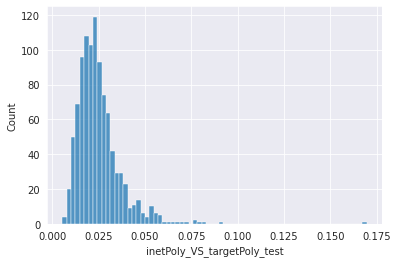

In [72]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

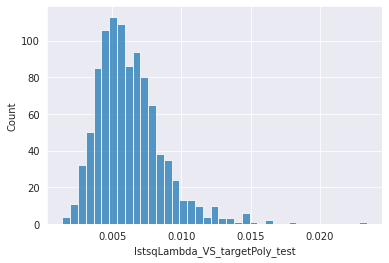

In [73]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

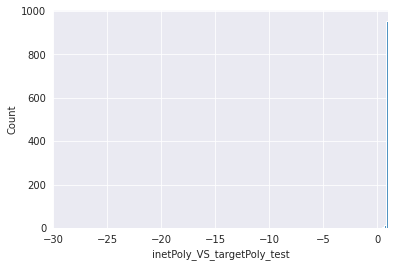

In [74]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

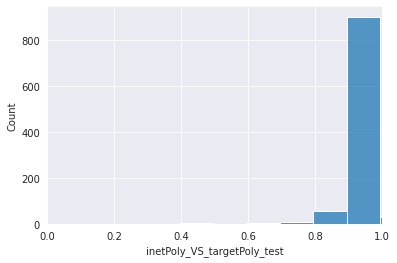

In [75]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

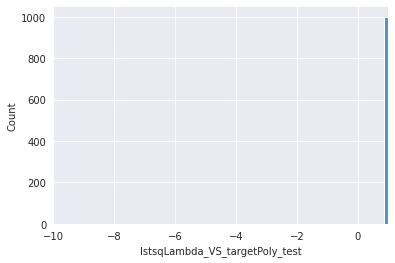

In [76]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

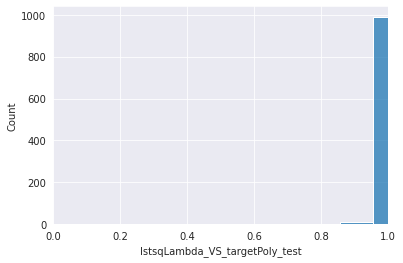

In [77]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [78]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [79]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [80]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [81]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [82]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [83]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


0.2147*a**1.0*b**1.0 + 0.0696*a**3.0*b**1.0 + 0.6333*a**3.0 + 0.6953*b**4.0*c**1.0 - 0.0086*b**4.0

LSTSQ Target Poly:


-1.2865*a**1.0*b**1.0*c**1.0 + 0.8169*a**1.0*b**1.0*c**2.0 - 0.2392*a**1.0*b**1.0*c**3.0 + 0.9846*a**1.0*b**1.0 + 1.2382*a**1.0*b**2.0*c**1.0 - 0.5121*a**1.0*b**2.0*c**2.0 - 1.7315*a**1.0*b**2.0 + 0.1613*a**1.0*b**3.0*c**1.0 + 1.397*a**1.0*b**3.0 - 0.4152*a**1.0*b**4.0 + 0.0635*a**1.0*c**1.0 + 0.2826*a**1.0*c**2.0 - 0.4153*a**1.0*c**3.0 + 0.2446*a**1.0*c**4.0 - 0.297*a**1.0 + 0.9969*a**2.0*b**1.0*c**1.0 + 0.0154*a**2.0*b**1.0*c**2.0 - 0.8335*a**2.0*b**1.0 - 1.0017*a**2.0*b**2.0*c**1.0 + 1.5106*a**2.0*b**2.0 - 0.6925*a**2.0*b**3.0 - 0.0417*a**2.0*c**1.0 - 0.318*a**2.0*c**2.0 + 0.0564*a**2.0*c**3.0 + 1.5972*a**2.0 - 0.1978*a**3.0*b**1.0*c**1.0 + 0.1295*a**3.0*b**1.0 - 0.2321*a**3.0*b**2.0 - 0.0027*a**3.0*c**1.0 + 0.068*a**3.0*c**2.0 - 3.4224*a**3.0 + 0.1754*a**4.0*b**1.0 + 0.0972*a**4.0*c**1.0 + 4.7159*a**4.0 - 2.0302*a**5.0 + 1.8863*b**1.0*c**1.0 - 2.2228*b**1.0*c**2.0 + 0.8941*b**1.0*c**3.0 + 0.1843*b**1.0*c**4.0 - 0.7161*b**1.0 - 5.1012*b**2.0*c**1.0 + 3.4389*b**2.0*c**2.0 - 1.5159*b*

LSTSQ Lambda Poly:


-1.2865*a**1.0*b**1.0*c**1.0 + 0.8169*a**1.0*b**1.0*c**2.0 - 0.2392*a**1.0*b**1.0*c**3.0 + 0.9846*a**1.0*b**1.0 + 1.2382*a**1.0*b**2.0*c**1.0 - 0.5121*a**1.0*b**2.0*c**2.0 - 1.7315*a**1.0*b**2.0 + 0.1613*a**1.0*b**3.0*c**1.0 + 1.397*a**1.0*b**3.0 - 0.4152*a**1.0*b**4.0 + 0.0635*a**1.0*c**1.0 + 0.2826*a**1.0*c**2.0 - 0.4153*a**1.0*c**3.0 + 0.2446*a**1.0*c**4.0 - 0.297*a**1.0 + 0.9969*a**2.0*b**1.0*c**1.0 + 0.0154*a**2.0*b**1.0*c**2.0 - 0.8335*a**2.0*b**1.0 - 1.0017*a**2.0*b**2.0*c**1.0 + 1.5106*a**2.0*b**2.0 - 0.6925*a**2.0*b**3.0 - 0.0417*a**2.0*c**1.0 - 0.318*a**2.0*c**2.0 + 0.0564*a**2.0*c**3.0 + 1.5972*a**2.0 - 0.1978*a**3.0*b**1.0*c**1.0 + 0.1295*a**3.0*b**1.0 - 0.2321*a**3.0*b**2.0 - 0.0027*a**3.0*c**1.0 + 0.068*a**3.0*c**2.0 - 3.4224*a**3.0 + 0.1754*a**4.0*b**1.0 + 0.0972*a**4.0*c**1.0 + 4.7159*a**4.0 - 2.0302*a**5.0 + 1.8863*b**1.0*c**1.0 - 2.2228*b**1.0*c**2.0 + 0.8941*b**1.0*c**3.0 + 0.1843*b**1.0*c**4.0 - 0.7161*b**1.0 - 5.1012*b**2.0*c**1.0 + 3.4389*b**2.0*c**2.0 - 1.5159*b*

I-Net Poly:


0.015599999576807*a**1.0*b**1.0*c**1.0 + 0.00870000012218952*a**1.0*b**1.0*c**2.0 - 0.0220999997109175*a**1.0*b**1.0*c**3.0 - 0.00899999961256981*a**1.0*b**1.0 + 0.0815000012516975*a**1.0*b**2.0*c**1.0 - 0.0187999997287989*a**1.0*b**2.0*c**2.0 + 0.0869000032544136*a**1.0*b**2.0 + 0.091499999165535*a**1.0*b**3.0*c**1.0 + 0.048700001090765*a**1.0*b**3.0 - 0.0190999992191792*a**1.0*b**4.0 + 0.00570000009611249*a**1.0*c**1.0 - 0.0394000001251698*a**1.0*c**2.0 + 0.0344999991357327*a**1.0*c**3.0 - 0.0582999996840954*a**1.0*c**4.0 + 0.0364000014960766*a**1.0 + 0.0142000000923872*a**2.0*b**1.0*c**1.0 - 0.0293000005185604*a**2.0*b**1.0*c**2.0 + 0.0882000029087067*a**2.0*b**1.0 - 0.0230999998748302*a**2.0*b**2.0*c**1.0 + 0.0658999979496002*a**2.0*b**2.0 - 0.089699998497963*a**2.0*b**3.0 + 0.0230000000447035*a**2.0*c**1.0 - 0.0293000005185604*a**2.0*c**2.0 - 0.0559000000357628*a**2.0*c**3.0 + 0.17339999973774*a**2.0 + 0.0724999979138374*a**3.0*b**1.0*c**1.0 + 0.16329999268055*a**3.0*b**1.0 - 0.05

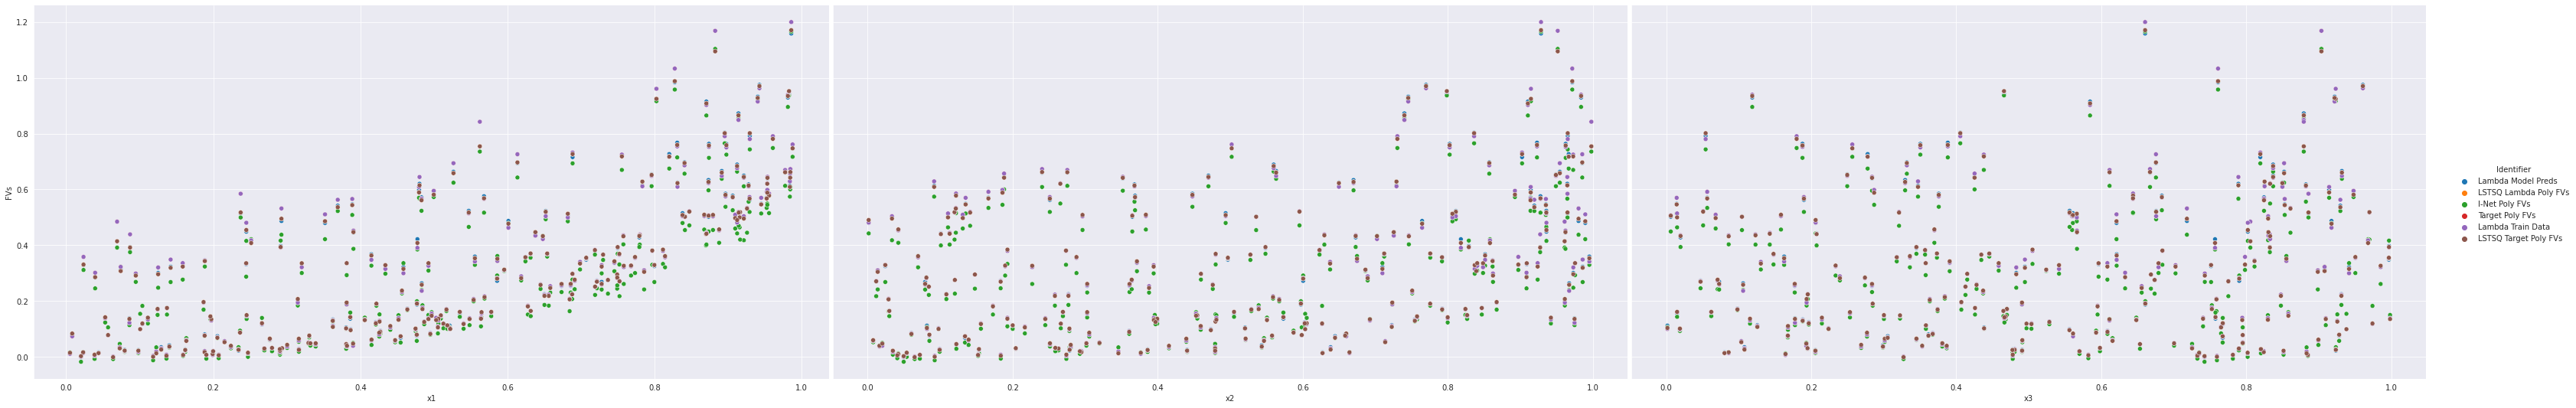

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.003546129768558895 | 0.9996960332349154 |   -    |           -1.2865*a**1.0*b**1.0*c**1.0 +           |
|            vs.            |                      |                    |        |           0.8169*a**1.0*b**1.0*c**2.0 -            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.2392*a**1.0*b**1.0*c**3.0 + 0.9846*a**1.0*b**1.0 |
|                           |                      |                    |        |          + 1.2382*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [84]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

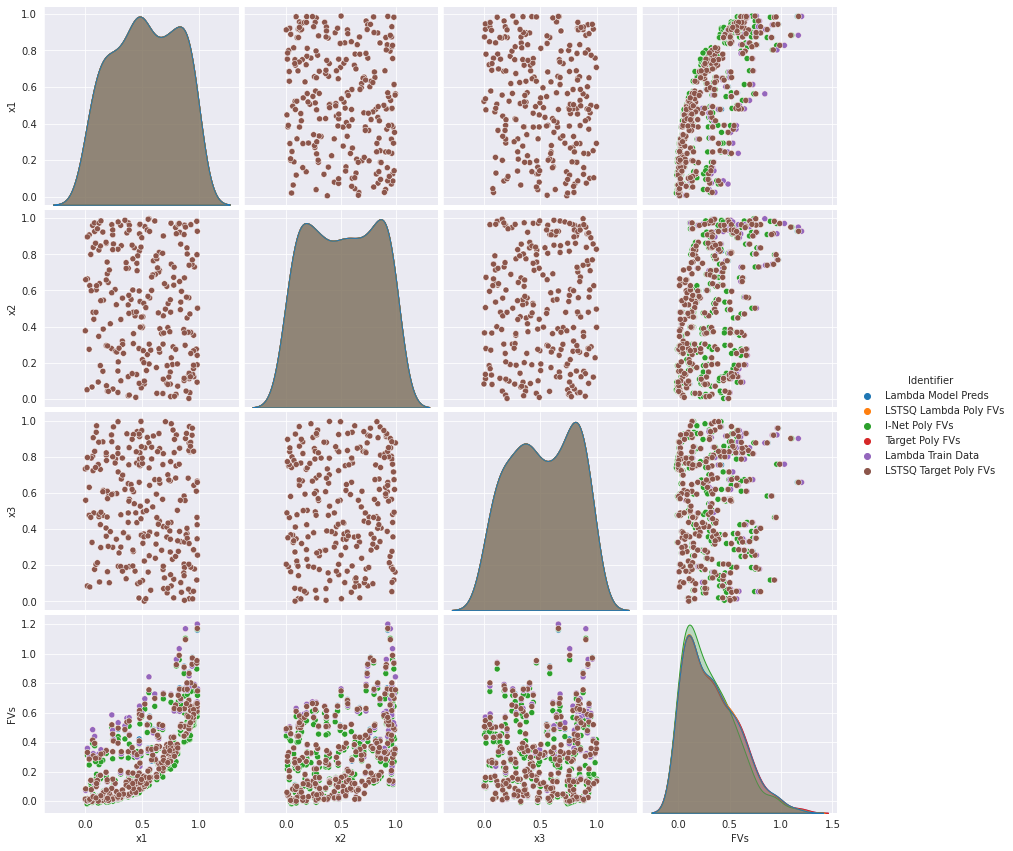

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.003546129768558895 | 0.9996960332349154 |   -    |           -1.2865*a**1.0*b**1.0*c**1.0 +           |
|            vs.            |                      |                    |        |           0.8169*a**1.0*b**1.0*c**2.0 -            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.2392*a**1.0*b**1.0*c**3.0 + 0.9846*a**1.0*b**1.0 |
|                           |                      |                    |        |          + 1.2382*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [85]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

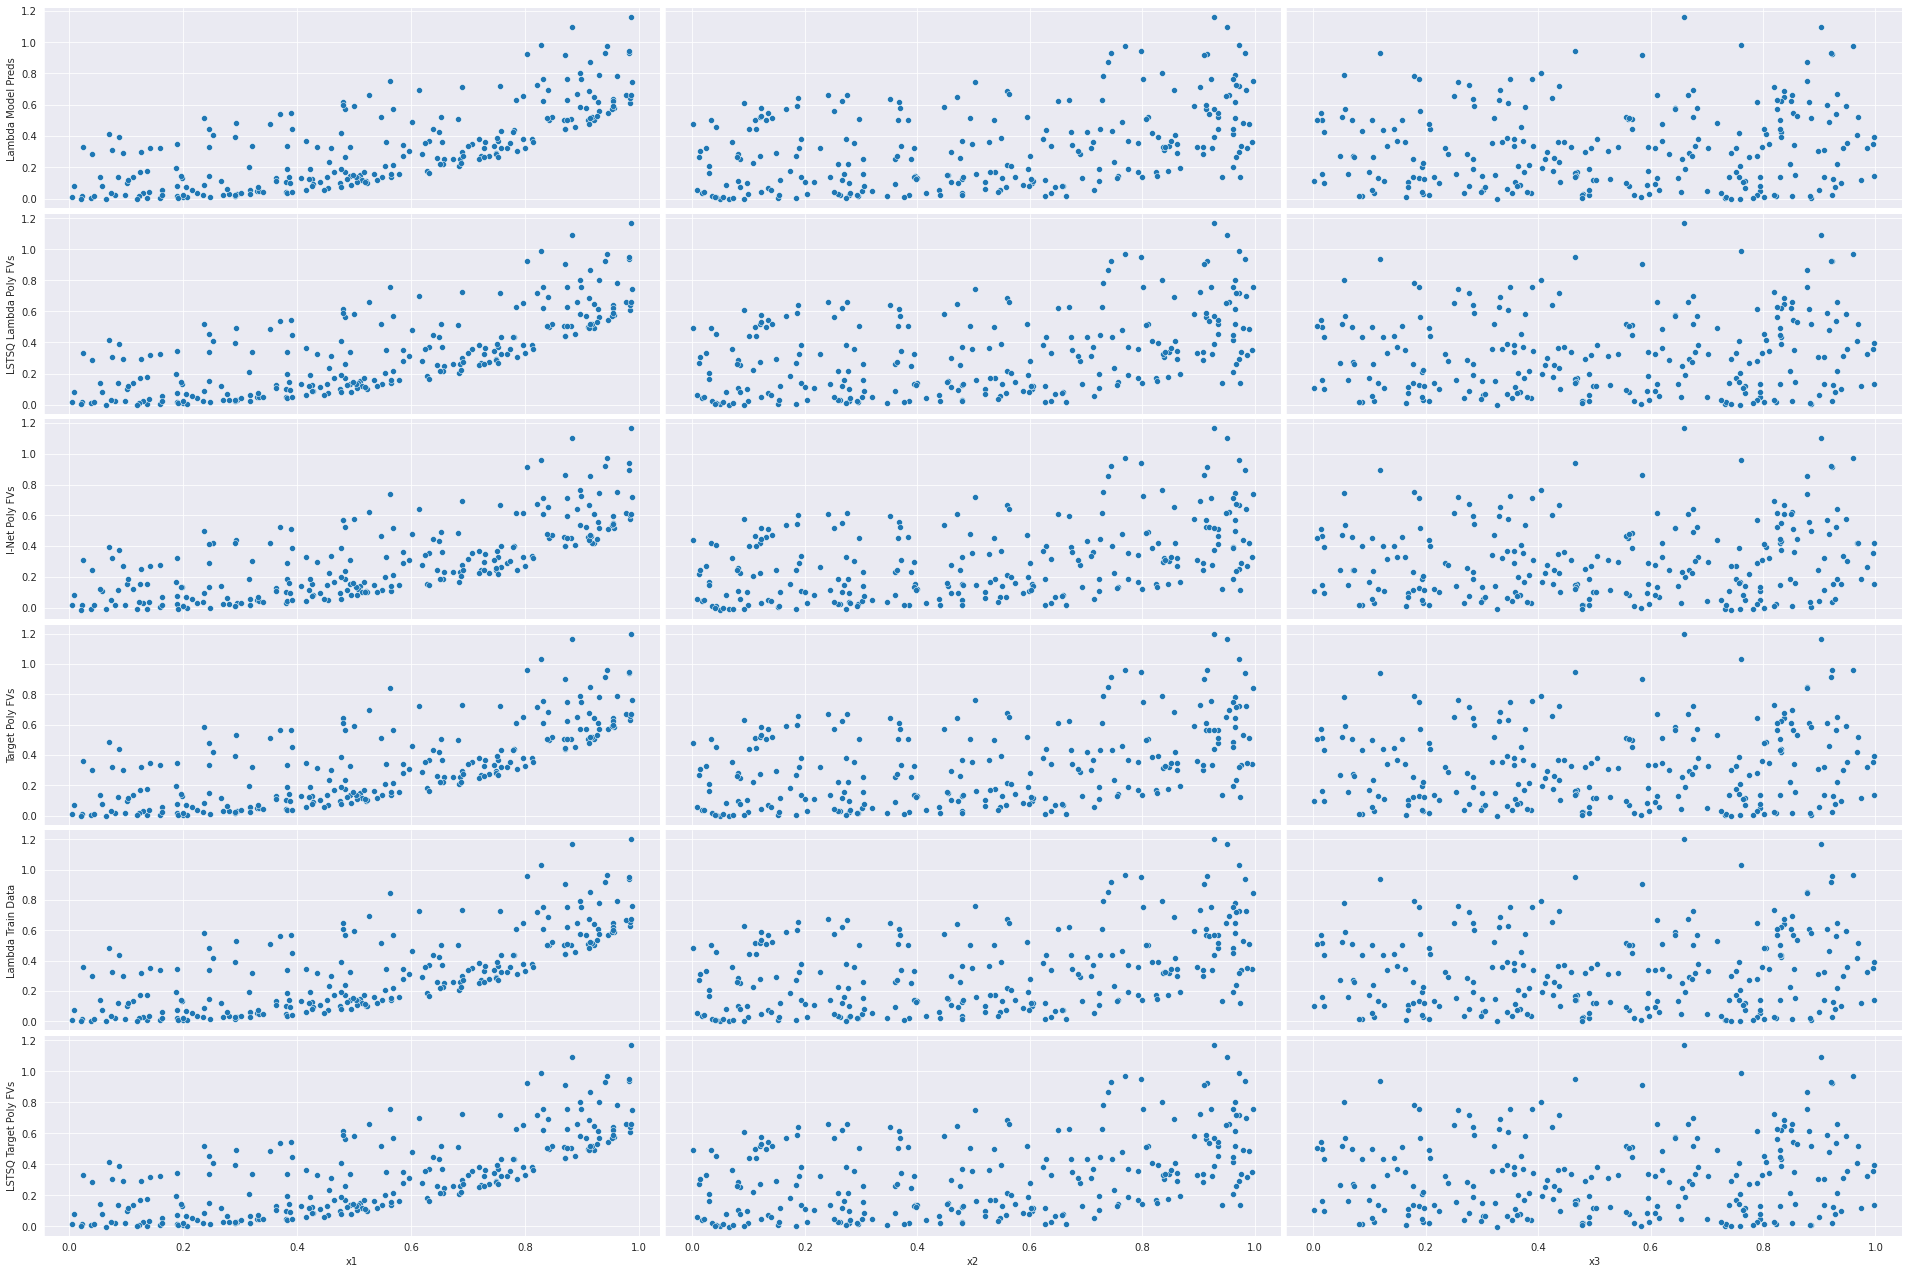

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.003546129768558895 | 0.9996960332349154 |   -    |           -1.2865*a**1.0*b**1.0*c**1.0 +           |
|            vs.            |                      |                    |        |           0.8169*a**1.0*b**1.0*c**2.0 -            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.2392*a**1.0*b**1.0*c**3.0 + 0.9846*a**1.0*b**1.0 |
|                           |                      |                    |        |          + 1.2382*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [86]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [87]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [88]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [89]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.9983


In [90]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 9.8614


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [91]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [92]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.2705


In [93]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [94]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()